# 觀察大局
- 業務目標
    - 預測台北市房屋總房價
    - 專注在住宅方面
- 機器學習問題分類
    - 監督式回歸問題
- 評分方式
    - hit-rate
- 基本假設
    - 與地坪、建坪、地區、建材、屋齡、學區、平均房間數有關

# 獲取資料
- 內政部「不動產交易實價登錄」提供的不動產買賣資料集

# 研究資料
- 利用dataframe操作副本, 維持原始資料乾淨
- 研究每個特徵
    - 缺失值百分比
    - 噪音
    - 分布類型
- 資料視覺化幫助觀察資料有無異狀
    - 相關係數(注意, 只觀察得到線性關係)
        - 熱力圖
        - scatter-matrix
    - 資料分布
        - 直方圖
        - 散步圖

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# 讀取原始資料

data = pd.read_csv('105-108o.csv')[1:]   # 第一筆為英文欄位名稱, 直接去掉

In [2]:
# 先稍微看一下原始資料, 查看資料型態、數值等等
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81165 entries, 1 to 81165
Data columns (total 28 columns):
鄉鎮市區            81165 non-null object
交易標的            81165 non-null object
土地區段位置建物區段門牌    81165 non-null object
土地移轉總面積平方公尺     81165 non-null object
都市土地使用分區        80347 non-null object
非都市土地使用分區       25 non-null object
非都市土地使用編定       14 non-null object
交易年月日           81165 non-null object
交易筆棟數           81165 non-null object
移轉層次            72868 non-null object
總樓層數            72757 non-null object
建物型態            81165 non-null object
主要用途            70619 non-null object
主要建材            72921 non-null object
建築完成年月          64870 non-null object
建物移轉總面積平方公尺     81165 non-null object
建物現況格局.房        81165 non-null object
建物現況格局.廳        81165 non-null object
建物現況格局.衛        81165 non-null object
建物現況格局.隔間       81165 non-null object
有無管理組織          81165 non-null object
總價元             81165 non-null object
單價元平方公尺         76271 non-null object
車位類別            28450 n

In [3]:
# 原始資料的資料分布概略情形, 可以知道因為太多非數值, 必須要轉換後才能看清
data.describe()

,鄉鎮市區,交易標的,土地區段位置建物區段門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,...,建物現況格局.衛,建物現況格局.隔間,有無管理組織,總價元,單價元平方公尺,車位類別,車位移轉總面積平方公尺,車位總價元,備註,編號
count,81165,81165,81165,81165,80347,25,14,81165,81165,72868,...,81165,81165,81165,81165,76271,28450,81165,81165,38625,81165
unique,13,6,15345,9963,6,2,1,2554,389,443,...,31,3,3,13191,61801,8,4940,789,6035,81152
top,中山區,房地(土地+建物),臺北市萬華區康定路91~120號,0.0,住,the non-metropolis land use district,non-metropolis land use,1050516,土地1建物1車位0,四層,...,1,有,有,12000000,0,坡道平面,0.0,0,含增建或未登記建物。,serial number
freq,11053,44860,747,842,46403,14,14,497,31561,8314,...,28702,73702,46069,765,665,20465,60039,65697,10309,14


In [4]:
# 接著看一下缺失值比例

def miss(x):
    return sum(pd.isnull(x)) / len(x)

miss_result = dict()

for column in data.columns:
    miss_result[column] = miss(data[column])

# 排序一下, 看比較清楚

miss_result = sorted(miss_result.items(), key=lambda s: s[1], reverse=True)  # 使用sorted, 然後用缺失比例來排序, 與就是s[1]
miss_result

[('非都市土地使用編定', 0.9998275118585597),
 ('非都市土地使用分區', 0.9996919854617138),
 ('車位類別', 0.6494794554302963),
 ('備註', 0.52411753834781),
 ('建築完成年月', 0.2007638760549498),
 ('主要用途', 0.12993285283065362),
 ('總樓層數', 0.10359144951641718),
 ('移轉層次', 0.10222386496642641),
 ('主要建材', 0.10157087414525966),
 ('單價元平方公尺', 0.0602969260149079),
 ('都市土地使用分區', 0.010078235692724697),
 ('鄉鎮市區', 0.0),
 ('交易標的', 0.0),
 ('土地區段位置建物區段門牌', 0.0),
 ('土地移轉總面積平方公尺', 0.0),
 ('交易年月日', 0.0),
 ('交易筆棟數', 0.0),
 ('建物型態', 0.0),
 ('建物移轉總面積平方公尺', 0.0),
 ('建物現況格局.房', 0.0),
 ('建物現況格局.廳', 0.0),
 ('建物現況格局.衛', 0.0),
 ('建物現況格局.隔間', 0.0),
 ('有無管理組織', 0.0),
 ('總價元', 0.0),
 ('車位移轉總面積平方公尺', 0.0),
 ('車位總價元', 0.0),
 ('編號', 0.0)]

# 準備數據、前處理
- 測試集20%
- 資料清理
    - 修復或者刪除異常值
    - 填補缺失值或者刪除該筆資料
- 特徵選擇(?)
    - 刪除不能為目標提供有效訊息的特徵
- 資料轉換
    - 轉化為數值
    - 分解特徵
        - 如日期切成年、季
    - 特徵轉換

In [20]:
# 資料清理、特徵選擇

# 根據我們討論結果, 非都市土地使用編定, 非都市土地使用分區欄位缺值比例過高
# 以及其他非研究相關標的、暫時無法處理的項目
# 門牌要好好考慮...經緯度重要嗎?但是因為台灣有點太小了, 感覺還好。

# 建物形態、建材、都市土地使用分區、交易標的 需要分別處理

del_columns = ['非都市土地使用編定', '非都市土地使用分區', '交易筆棟數', '編號', '備註', '車位類別', '土地區段位置建物區段門牌']
data = data.drop(columns=del_columns)

# 上面等博仁資料我再繼續做...

# 期望模型
- 模型選擇
    - 線性回歸
    - 決策樹
    - 隨機森林
    - SVM
        - 資料大會跑不動...
- 若數據量很大, 需要用抽樣方法快速測試
- 先使用默認參數來檢視基礎模型
- 接著比較其性能
    - 交叉驗證, 看均值及其標準差(metrics)
- 分析每個模型最重要的超參數
- 分析模型產生錯誤
    - overfitting
    - 時間窺探
- 快速進行特徵選擇與處理
    - 根據特徵重要性
- 保存模型

In [1]:
import numpy as np
import pandas as pd
# 將資料分成X, y
data = pd.read_csv('105-108data2.csv')   # 前處理完的資料

# 這是完整檔案
y = pd.DataFrame(data['總價元'])  # 要改成總價
y = np.array(y).flatten()        # 把shape 修正正確


# 這邊記得要開, 是因為關係數先把資料關起來了
# 行政區
# data = data.drop(columns=['總價元', '單價元平方公尺', '區總價'])
# 區總價
# data = data.drop(columns=['總價元', '單價元平方公尺', '士林區', '大同區', '大安區', '中山區', '中正區', '內湖區', '文山區', '北投區', '松山區', '信義區',
#        '南港區', '萬華區'])

X = data.drop(columns=['總價元', '單價元平方公尺', '區總價'])

In [2]:
# 前處過後資料筆數
X.shape

(57663, 58)

In [3]:
# 將資料按照年份切分, 避免時間窺探
X_105 = X[np.where(X['交易年月日'] <= 105, True, False)]
X_106 = X[np.where(X['交易年月日'] <= 106, True, False)]
X_107 = X[np.where(X['交易年月日'] <= 107, True, False)]
X_108 = X[np.where(X['交易年月日'] <= 108, True, False)]

print(X_108['交易年月日'].value_counts())

107    15010
106    14353
105    12947
108     7868
104     5400
103      909
102      798
101      378
Name: 交易年月日, dtype: int64


In [4]:
# 將模型評估融入scikit-learn方便之後觀察。
from sklearn.metrics import make_scorer
import numpy as np

def display_scores(scores):
    """
    模型評估分數的展示
    """
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def hit_rate(y_pred, y_real, threshold=0.1):
    """
    模型評估, hit-rate
    """
    y_pred = np.array(y_pred)
    y_real = np.array(y_real)
    z = np.abs(y_pred - y_real) / y_real
    z = np.where(z <= threshold, 1, 0)

    return np.sum(z) / y_pred.shape[0]

# 建立自己的模型評估
hit_rate_scorer = make_scorer(hit_rate, greater_is_better = True)

In [5]:
# 訓練集與測試集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 線性回歸model、決策樹、隨機森林
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings                             # 忽略警告
warnings.filterwarnings('ignore')

# 模型初始化, 先用默認參數
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
svm = SVR()

# 裝在dict, 方便一次處理
models = {'線性回歸': lr, '決策樹': dt, '隨機森林': rf, '支持向量機': svm}

for name, model in models.items():
    print(name)
    scores = cross_val_score(model, X_train, y_train, scoring=hit_rate_scorer, cv=10)
    display_scores(scores)
    print()

線性回歸
Scores: [0.23043573 0.24734446 0.2408411  0.24994581 0.24040754 0.24626057
 0.22783438 0.23802298 0.23498808 0.24474312]
Mean: 0.24008237589421202
Standard deviation: 0.0069560285736230435

決策樹
Scores: [0.44894862 0.44743117 0.43637546 0.43355734 0.4430956  0.43680902
 0.45393453 0.4389768  0.43615868 0.44699762]
Mean: 0.44222848471710385
Standard deviation: 0.006472939908939474

隨機森林
Scores: [0.49577282 0.4949057  0.48515066 0.46975938 0.49143724 0.4816822
 0.49447214 0.48666811 0.4888359  0.48775201]
Mean: 0.4876436158681986
Standard deviation: 0.007374458570636914

支持向量機
Scores: [0.10925645 0.11034034 0.11229135 0.09841752 0.10687188 0.09928463
 0.11055712 0.09798396 0.107739   0.11099068]
Mean: 0.1063732928679818
Standard deviation: 0.005328567845871182



# 微調模型
- 使用交叉驗證微調模型超參數
- 嘗試集成學習, 組合多個好模型往往比單個模型來得好
- 得到最終模型, 在測試集上測量性能

# 啟動、監控和維護系統
- 監控系統效能
- 評估輸入系統的資料品質
- 定期用新的資料訓練
    - 同時也要保有彈性, 可以回溯之前的模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 模型測試

- 三種模型測試
    - 隨機森林
    - GDBT
    - 線性回歸
    - 神經網路
- 超參數搜尋
    - Grid Search
    - Random Search
    - Stimulated anealing
- 模型評估
    - MSE
    - R2
    - hit-rate

# 原始資料的相關性
- 熱力圖~~~

In [3]:
# 相關係數

corr_matrix = data.corr()       # 直接得到相關係數的矩陣
target_corr = corr_matrix['總價元'].sort_values(ascending=False)   # 這個要有x有y的, 對總價元的相關係數, 大到小排列
target_corr

總價元                    1.000000
建物移轉總面積平方公尺            0.944707
土地移轉總面積平方公尺            0.778160
車位移轉總面積平方公尺            0.325848
車位總價元                  0.196568
單價元平方公尺                0.165643
交易標的.房地.車位             0.137855
總樓層數                   0.127668
建物型態.辦公商業大樓            0.124948
主要用途.住家用               0.124948
區總價                    0.114391
建物現況格局.衛               0.099475
建物型態.住宅大樓.11層含以上有電梯    0.081197
主要用途.停車空間              0.081197
建物現況格局.房               0.078080
移轉層次                   0.076787
有無管理組織                 0.060481
都市土地使用分區.其他            0.053593
都市土地使用分區.工             0.048581
大安區                    0.033517
內湖區                    0.021742
建物型態.透天厝               0.020678
主要用途.見使用執照             0.020678
透天厝                    0.020678
建物現況格局.廳               0.019686
信義區                    0.017238
中正區                    0.014007
見其他登記事項                0.013777
松山區                    0.011115
中山區                    0.009833
                         ...   
Q3      

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
plt.style.use('ggplot')

# 忽略警告訊息
%matplotlib inline
import warnings                             # 忽略警告
warnings.filterwarnings('ignore')

# 顯示中文字, note內有, 解決Python3那個
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

plt.figure(figsize = (15, 10))            # 設定figsize, 很直觀
# 繪製相關係數 (correlations) 的 Heatmap
# note:
# cmap: colors, 有需要自己調色再去查, 不然不設定也是無所謂
# vmin: 顏色值的最小值
# vmax: 顏色值的最大值
# annot: 註釋資料
# f, (ax1,ax2) = plt.subplots(figsize = (18, 12),nrows=2)

# sns.heatmap(corr_matrix, cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0)
# plt.title('熱力圖')


# 只畫這些

negative_top_ten = list(target_corr[-9:].index)
negative_top_ten.insert(0, '總價元')

positive_top_ten = data[target_corr[:10].index]
negative_top_ten = data[negative_top_ten]

positive_top_ten_corr = positive_top_ten.corr()
negative_top_ten_corr = negative_top_ten.corr()

plt.subplot(211)
sns.heatmap(positive_top_ten_corr, cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0, linewidths=1)
plt.title('+top10 - 熱力圖')

plt.subplot(212)
sns.heatmap(negative_top_ten_corr, cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0, linewidths=1)
plt.title('-top10 - 熱力圖')
# positive_top_ten_corr


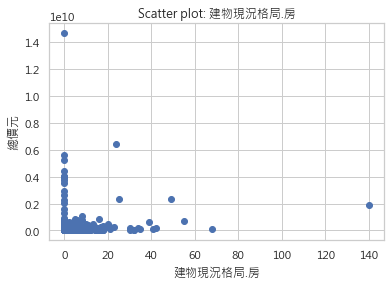

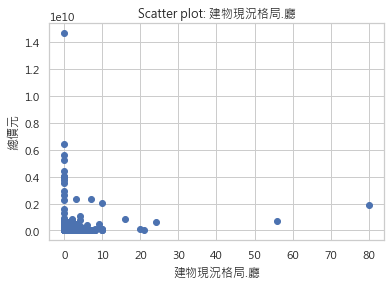

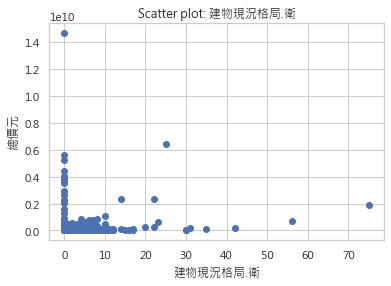

In [24]:
# draw scatter plots

# 忽略警告訊息
%matplotlib inline
import warnings                             
warnings.filterwarnings('ignore')

# 顯示中文字, note內有, 解決Python3那個
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plot_lists = ['建物現況格局.房', '建物現況格局.廳', '建物現況格局.衛']


for c in plot_lists:
    plt.scatter(data[c], np.log(y))   # 要用log轉換嗎??
    plt.title('Scatter plot: ' + c)
    plt.xlabel(c)
    plt.ylabel('總價元')
    plt.show()

In [25]:
# 參考用

# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# f, (ax1,ax2) = plt.subplots(figsize = (6, 4),nrows=2) 
# #corr_matrix:61*61
# sns.heatmap(corr_matrix, cmap = plt.cm.RdYlBu_r, annot=True, fmt='.3g', ax = ax1)
# ax1.set_xticklabels([])
# ax1.set_yticklabels([])

In [26]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# f, (ax1,ax2) = plt.subplots(figsize = (6, 4),nrows=2) 
# #corr_matrix:61*61
# sns.heatmap(corr_matrix, cmap = plt.cm.RdYlBu_r, annot=True, fmt='.3g', ax = ax1)
# ax1.set_xticklabels([])
# ax1.set_yticklabels([])

In [5]:
# 看一下~~
data.columns

Index(['士林區', '大同區', '大安區', '中山區', '中正區', '內湖區', '文山區', '北投區', '松山區', '信義區',
       '南港區', '萬華區', '交易標的.房地.車位', '交易標的.房地', '交易標的.建物', '都市土地使用分區.住',
       '都市土地使用分區.商', '都市土地使用分區.工', '都市土地使用分區.其他', '建物型態.辦公商業大樓',
       '建物型態.公寓.5樓含以下無電梯', '建物型態.華廈.10層含以下有電梯', '建物型態.套房.1房1廳1衛',
       '建物型態.住宅大樓.11層含以上有電梯', '建物型態.透天厝', '主要用途.住家用', '主要用途.住商用', '主要用途.住工用',
       '主要用途.國民住宅', '主要用途.停車空間', '主要用途.見使用執照', '土地移轉總面積平方公尺', '交易年月日', 'Q1',
       'Q2', 'Q3', 'Q4', '移轉層次', '陽台', '騎樓', '平台', '走廊', '電梯樓梯間', '透天厝', '停車場',
       '夾層', '露台', '見其他登記事項', '總樓層數', '屋齡', '建物移轉總面積平方公尺', '建物現況格局.房',
       '建物現況格局.廳', '建物現況格局.衛', '建物現況格局.隔間', '有無管理組織', '車位移轉總面積平方公尺', '車位總價元'],
      dtype='object')

In [7]:
# 新增房價指數

def fill_hp(data):
    hp = {
        '1080010': 281.66, '1080100': 284.13, '1081000': 280.45,
        '1070001': 279.76, '1070010': 278.04, '1070100': 275.93, '1071000': 276.3,
        '1060001': 267.73, '1060010': 271.57, '1060100': 273.97, '1061000': 274.44,
        '1050001': 270.97, '1050010': 269.52, '1050100': 276.76, '1051000': 271.36,
        '1040001': 273.98, '1040010': 286.22, '1040100': 289.6, '1041000': 302.06,
        '1030001': 294.26, '1030010': 297.45, '1030100': 310.2, '1031000': 298.5,
        '1020001': 304.85, '1020010': 294.89, '1020100': 292.94, '1021000': 284.55,
        '1010001': 269.15, '1010010': 268.28, '1010100': 262.7, '1011000': 254.19
    }
    return hp[data]

# 增加房價指數

data['HP'] = data['交易年月日'].astype(str) + data['Q1'].astype(str) + data['Q2'].astype(str) + data['Q3'].astype(str) + data['Q4'].astype(str)
data['HP'] = data['HP'].apply(fill_hp)

In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate




rndf = RandomForestRegressor(random_state=42)
scores = cross_validate(rndf, X, y, cv=3,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

scores

C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'fit_time': array([10.35202026,  8.65809703,  8.41630292]),
 'score_time': array([0.39098096, 0.32295942, 0.2258749 ]),
 'test_r2': array([0.84199092, 0.6599875 , 0.89046673]),
 'train_r2': array([0.96246966, 0.97105467, 0.97956577]),
 'test_neg_mean_squared_error': array([-1.16116618e+15, -4.79100906e+15, -6.22094543e+14]),
 'train_neg_mean_squared_error': array([-3.70992848e+14, -1.88553267e+14, -2.19049859e+14])}

In [6]:
# 隨機森林+GridSearch

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV #GridSearchCV找最好超參數的值

param_grid = {'n_estimators': [3, 10, 30, 100], 'max_features': [2, 4, 6, 8], 'max_depth': [1, 10, 100]} #n_estimators:代表有幾棵樹
  

forest_reg = RandomForestRegressor(random_state=42, min_samples_leaf=2)


grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring=('r2', 'neg_mean_squared_error'),
                           refit='r2',
                           return_train_score=True)

In [7]:
# 開始~~
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=2,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 10, 100],
      

In [61]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_train_r2', 'split1_train_r2', 'split2_train_r2', 'split3_train_r2', 'split4_train_r2', 'mean_train_r2', 'std_train_r2', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'split0_train_neg_mean_squared_error', 'split1_train_neg_mean_squared_error', 'split2_train_neg_mean_squared_error', 'split3_train_neg_mean_squared_error', 'split4_train_neg_mean_squared_error', 'mean_train_neg_mean_squared_error', 'std_train_neg_mean_squared_error'])

In [64]:
# 看結果
# {'max_depth': 100, 'max_features': 8, 'n_estimators': 30}
# 55475786.34929788 {'max_depth': 10, 'max_features': 8, 'n_estimators': 30}
# print(grid_search.cv_results_)
best_params = grid_search.best_params_
# print(grid_search.best_score_)

#看各組的成績

# cvres = grid_search.cv_results_
for mean_test_neg_mean_squared_error, params in zip(cvres["mean_test_neg_mean_squared_error"], cvres["params"]):
    print((np.sqrt(-mean_test_neg_mean_squared_error)), params)

93767874.25258799 {'max_depth': 1, 'max_features': 2, 'n_estimators': 3}
94375563.43586609 {'max_depth': 1, 'max_features': 2, 'n_estimators': 10}
94492213.73708193 {'max_depth': 1, 'max_features': 2, 'n_estimators': 30}
92334804.2655327 {'max_depth': 1, 'max_features': 2, 'n_estimators': 100}
95075575.73919816 {'max_depth': 1, 'max_features': 4, 'n_estimators': 3}
93789583.15549038 {'max_depth': 1, 'max_features': 4, 'n_estimators': 10}
93419363.04064764 {'max_depth': 1, 'max_features': 4, 'n_estimators': 30}
90363843.75624333 {'max_depth': 1, 'max_features': 4, 'n_estimators': 100}
95083697.94401541 {'max_depth': 1, 'max_features': 6, 'n_estimators': 3}
90932097.14102244 {'max_depth': 1, 'max_features': 6, 'n_estimators': 10}
88412969.03760062 {'max_depth': 1, 'max_features': 6, 'n_estimators': 30}
87435708.28036955 {'max_depth': 1, 'max_features': 6, 'n_estimators': 100}
83065004.7854042 {'max_depth': 1, 'max_features': 8, 'n_estimators': 3}
80188171.03481406 {'max_depth': 1, 'max_f

In [65]:
# 最佳參數的樹
# oob_score看袋外分數
rnd = RandomForestRegressor(max_depth=100, max_features=8, n_estimators=100, min_samples_leaf=3, random_state=42, oob_score=True)

rnd.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [66]:
print(rnd.oob_score_)

0.5962552154186935


In [ ]:
# 調參前
# {'fit_time': array([10.35202026,  8.65809703,  8.41630292]),
#  'score_time': array([0.39098096, 0.32295942, 0.2258749 ]),
#  'test_r2': array([0.84199092, 0.6599875 , 0.89046673]),
#  'train_r2': array([0.96246966, 0.97105467, 0.97956577]),
#  'test_neg_mean_squared_error': array([-1.16116618e+15, -4.79100906e+15, -6.22094543e+14]),
#  'train_neg_mean_squared_error': array([-3.70992848e+14, -1.88553267e+14, -2.19049859e+14])}

# 

In [28]:
# 資料切分成測試集、訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 改成特徵和0.9
# X_train, X_test = X_train[columns], X_test[columns]

# 隨機森林擬合後, 將結果依照重要性由高到低排序
from sklearn.ensemble import RandomForestRegressor

rndf = RandomForestRegressor(random_state=42)
rndf.fit(X_train, y_train)
rndf.feature_importances_   # 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=rndf.feature_importances_, index=X.columns)
feats = feats.sort_values(ascending=False)
feats

建物移轉總面積平方公尺            8.181643e-01
土地移轉總面積平方公尺            9.006272e-02
屋齡                     1.967433e-02
總樓層數                   1.374432e-02
建物現況格局.房               1.018016e-02
區總價                    8.757726e-03
建物現況格局.廳               5.215732e-03
建物現況格局.衛               4.366826e-03
車位移轉總面積平方公尺            3.942806e-03
車位總價元                  3.803639e-03
有無管理組織                 2.206555e-03
松山區                    2.187584e-03
建物現況格局.隔間              2.164274e-03
信義區                    2.036203e-03
移轉層次                   1.591301e-03
都市土地使用分區.商             1.412589e-03
內湖區                    1.281005e-03
大安區                    8.557995e-04
交易年月日                  8.432962e-04
交易標的.房地.車位             8.363557e-04
Q3                     7.720321e-04
都市土地使用分區.其他            7.644279e-04
建物型態.住宅大樓.11層含以上有電梯    7.104101e-04
主要用途.停車空間              7.091437e-04
中山區                    6.326997e-04
中正區                    5.889384e-04
Q4                     2.474501e-04
主要用途.住家用               2.307

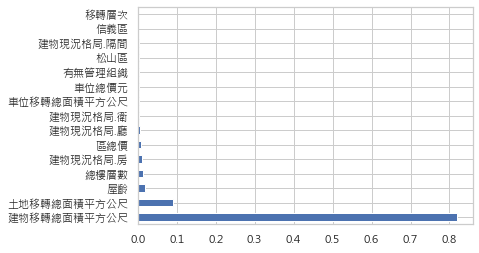

In [29]:
# 特徵重要性畫圖
feat_importances = feats.nlargest(15)
feat_importances.plot(kind='barh')

In [36]:
def get_feature_based_import(data, percent):
    """
    求取多少%的特徵，根據特徵重要性排序之後, 加總特徵數而不是重要性
    """
    length = len(data)               # 總特徵數
    count = int(length * percent)    # 多少%的特徵數, 無條件捨去
    i = 0
    columns = []
    for index in feats.index:
        i += 1
        columns.append(index)
        if i == count:
            return columns

columns = get_feature_based_import(feats, 0.5)
print(columns, len(feats), len(columns))

# data[columns].to_csv('90%特徵original_HP.csv')

['建物移轉總面積平方公尺', '土地移轉總面積平方公尺', '屋齡', '總樓層數', '建物現況格局.房', '區總價', '建物現況格局.廳', '建物現況格局.衛', '車位移轉總面積平方公尺', '車位總價元', '有無管理組織', '松山區', '建物現況格局.隔間', '信義區', '移轉層次', '都市土地使用分區.商', '內湖區', '大安區', '交易年月日', '交易標的.房地.車位', 'Q3', '都市土地使用分區.其他', '建物型態.住宅大樓.11層含以上有電梯', '主要用途.停車空間', '中山區', '中正區', 'Q4', '主要用途.住家用', '建物型態.透天厝'] 59 29


# 利用特徵重要性擷取新的特徵
- 然後再依此跑模型
- 檢驗效果還可以嗎?
    - 如果還行, 就可以減少計算量

In [ ]:
# 信義房價指數補column
# 利用dict來處理
# 這裡是用季資料，但不知道好不好

# def fill_hp(data):
#     hp = {
#         '1080010': 281.66, '1080100': 284.13, '1081000': 280.45,
#         '1070001': 279.76, '1070010': 278.04, '1070100': 275.93, '1071000': 276.3,
#         '1060001': 267.73, '1060010': 271.57, '1060100': 273.97, '1061000': 274.44,
#         '1050001': 270.97, '1050010': 269.52, '1050100': 276.76, '1051000': 271.36,
#         '1040001': 273.98, '1040010': 286.22, '1040100': 289.6, '1041000': 302.06,
#         '1030001': 294.26, '1030010': 297.45, '1030100': 310.2, '1031000': 298.5,
#         '1020001': 304.85, '1020010': 294.89, '1020100': 292.94, '1021000': 284.55,
#         '1010001': 269.15, '1010010': 268.28, '1010100': 262.7, '1011000': 254.19
#     }
#     return hp[data]

# # 增加房價指數

# data['HP'] = data['交易年月日'].astype(str) + data['Q1'].astype(str) + data['Q2'].astype(str) + data['Q3'].astype(str) + data['Q4'].astype(str)
# data['HP'] = data['HP'].apply(fill_hp)

In [12]:
# 特徵重要性大概多少%的選擇資料

def get_feature_percent(original_feats, percent):
    result = 0
    percent_columns = []
    for i, v in enumerate(original_feats):
        result += v
        percent_columns.append(original_feats.index[i])
        if result >= percent:
            break
    return percent_columns

percent_columns = get_feature_percent(feats, 0.90)

print(get_feature_percent(feats, 0.9))
# # 存成csv
# data[get_feature_percent(feats, 0.9)].to_csv('90%data_區總價_HP.csv')

['建物移轉總面積平方公尺', '土地移轉總面積平方公尺']


In [23]:
# ..快速弄的
# data[['土地移轉總面積平方公尺', '建物移轉總面積平方公尺', 'HP']].to_csv('data2_HP.csv')

In [31]:
# 模型評價
# hit-rate

def hit_rate(y_pred, y_real, threshold):
    y_pred = np.array(y_pred)
    y_real = np.array(y_real)
    z = (y_pred - y_real) / y_real
    z = np.where(z <= threshold, 1, 0)

    return np.sum(z) / y_pred.shape[0]

In [41]:
print(X_train.shape)
print(y_train.shape)

(46130, 29)
(46130,)


In [40]:
# 模型選擇、測試
# 隨機森林~~~~~~~
from sklearn.metrics import mean_squared_error, r2_score

# y_pred = rndf.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# 90%DATA
X_test = X_test[columns]
X_train = X_train[columns]

# model train and predict
rndf = RandomForestRegressor(n_estimators=100, random_state=42)
rndf.fit(X_train, y_train)
rndf.feature_importances_   # 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表

y_pred = rndf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: {}'.format(mse))
print('R2: {}'.format(r2))
print(hit_rate(y_pred, y_test, 0.1))
print(hit_rate(y_pred, y_test, 0.2))

MSE: 263947831090175.88
R2: 0.9267870443560151
0.7316396427642418
0.8335212000346831


- 原始data，只有行政區
    MSE: 2194253255.031558
    R2: 0.6756984755008102
    0.7043267146449319
    0.8189543050377178

- 行政區+房價指數
    MSE: 2590552231.870406
    R2: 0.6171271314448756
    0.7123038238099367
    0.8145322119136391

- 區總價+房價指數
    MSE: 2743029031.806832
    R2: 0.5945916932238078
    0.7314662273476112
    0.8295326454521808

- 區總價+行政區+房價指數
    MSE: 3308997296.129144
    R2: 0.510943932639651
    0.7286048729732073
    0.8310933842018555

In [9]:
# gdbt模型~~~~測試
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# 模型
gdbt = GradientBoostingRegressor()

# 設定要訓練的超參數組合
n_estimators = [100, 200, 300]
max_depth = [1, 3, 5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)


## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(gdbt, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(X_train, y_train)

# 預設會跑 3-fold cross-validadtion，總共 9 種參數組合，總共要 train 27 次模型

C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   30.9s finished


In [10]:
# 印出最佳結果與最佳參數
grid_result.best_params_

{'max_depth': 1, 'n_estimators': 300}

In [11]:
# 使用最佳參數重新建立模型
from sklearn.metrics import mean_squared_error, r2_score
gdbt_bestparam = GradientBoostingRegressor(max_depth=grid_result.best_params_['max_depth'],
                                           n_estimators=grid_result.best_params_['n_estimators'])

# 訓練模型
gdbt_bestparam.fit(X_train, y_train)

# 預測測試集
y_pred = gdbt_bestparam.predict(X_test)

# 看一下mse、R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: {}'.format(mse))
print('R2: {}'.format(r2))
print(hit_rate(y_pred, y_test, 0.1))
print(hit_rate(y_pred, y_test, 0.2))

MSE: 625272760220264.9
R2: 0.8265639589826427
0.5133096332263938
0.6042660192491113


- 行政區+房價指數
    MSE: 2189095124.76073
    R2: 0.6764608257475555
    0.702419145061996
    0.8206884592040232

- 區總價+房價指數

# 測試結果

    - 行政區比區總價的效果還要好。
    - 加入房價指數有更好一些。

In [11]:
# 測試神經網路


In [25]:
# 查看資料的敘述統計
for column in data.columns:
    print(pd.DataFrame(data[column].describe()))

                士林區
count  57663.000000
mean       0.085792
std        0.280058
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
                大同區
count  57663.000000
mean       0.042055
std        0.200716
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
                大安區
count  57663.000000
mean       0.072213
std        0.258842
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
                中山區
count  57663.000000
mean       0.150946
std        0.357999
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
                中正區
count  57663.000000
mean       0.055443
std        0.228845
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
                內湖區
count  57663.000000
mean       0.136448
std        0.343267
min        0.000000


           建物現況格局.房
count  57663.000000
mean       2.366335
std        1.598269
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max      140.000000
           建物現況格局.廳
count  57663.000000
mean       1.523004
std        0.853019
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max       80.000000
           建物現況格局.衛
count  57663.000000
mean       1.511905
std        1.017106
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       75.000000
          建物現況格局.隔間
count  57663.000000
mean       0.912197
std        0.283011
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
             有無管理組織
count  57663.000000
mean       0.666823
std        0.471353
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
        車位移轉總面積平方公尺
count  57663.000000
mean      13.616912
std       62.755003
min        0.000000
